In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
def member_str_to_dict(member, committee):
    '''
    This function takes a string containing the name of the 
    committee member and other information and uses it to create 
    a dict that can then be used by pandas.
    '''
    # create the object with the committee name
    record = {"committee": committee}
    # split into two parts
    left, right = tuple(member.split(" ("))
    # extract the title (Sen or Rep) and the name from the left part
    record["title"], name = tuple(left.split(". ", maxsplit=1))
    # if the member has a second title (i.e. "Chair"), add that as a role
    if len(name.split(", ")) > 1:
        record["name"], record["role"] = tuple(name.split(", ", maxsplit=1))
    # also check if asterisk is present at the end
    elif right[-1] == '*':
        record["role"] = "Ranking Minority Party Member"
        right = right[:-1]
    # otherwise, set role to None
    else:
        record["name"], record["role"] = name, None
    
    # split on hyphen to extract party and town
    if len(right[:-1].split("-", maxsplit=1)) == 2:
        record["party"], record["town"] = tuple(right[:-1].split("-", maxsplit=1))
    # catch the case where no party is listed (e.g. Passamaquoddy representative)
    else:
        record["party"], record["town"] = right[:-1], right[:-1]
    return record

# Example output
print("EXAMPLE OUTPUT")
test_member = "Rep. William D. Pluecker, Chair (I-Warren)"
test_committee = "Agriculture, Conservation and Forestry"
print("Function call: member_str_to_dict({}, {})".format(test_member, test_committee))
print("Output: {}".format(member_str_to_dict(test_member, test_committee)))

EXAMPLE OUTPUT
Function call: member_str_to_dict(Rep. William D. Pluecker, Chair (I-Warren), Agriculture, Conservation and Forestry)
Output: {'committee': 'Agriculture, Conservation and Forestry', 'title': 'Rep', 'name': 'William D. Pluecker', 'role': 'Chair', 'party': 'I', 'town': 'Warren'}


In [3]:
# read the text file (copied from https://mainepolicy.org/committee-assignments-for-the-131st-legislature/)
with open("committee_list.txt", 'rt') as file:
    text = file.readlines()

# convert to a list of members
members = []
committee_name = None
i = 1
while i < len(text):
    if text[i] == '\n': # indicates we are at the start of a new committee
        i += 1
        committee_name = text[i].strip()
    else:
        members.append(member_str_to_dict(text[i].strip(), committee_name))
    i += 1

# turn it into a DataFrame
members = pd.DataFrame.from_records(members)

In [4]:
# # write dataframe to file
# members.to_csv("committee_list.csv")

In [5]:
# How many members are on each committee?
members.groupby("committee")["name"].count()

committee
Agriculture, Conservation and Forestry                        12
Appropriations and Financial Affairs                          12
Criminal Justice and Public Safety                            12
Education and Cultural Affairs                                12
Energy, Utilities and Technology                              12
Environment and Natural Resources                             12
Government Oversight Committee                                11
Health Coverage, Insurance and Financial Services             12
Health and Human Services                                     12
Inland Fisheries and Wildlife                                 12
Innovation, Development, Economic Advancement and Business    12
Joint Select Committee on Housing                             12
Judiciary                                                     13
Labor and Housing                                             12
Marine Resources                                              12
State and Local

Text(0, 0.5, 'Number of Members')

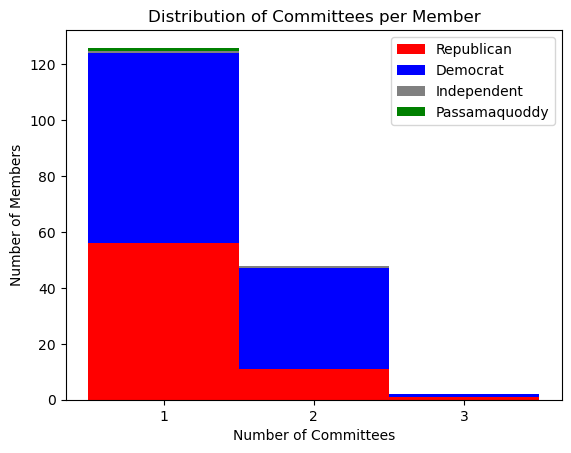

In [6]:
# How many committees is each member on?
committee_counts = members.groupby(["party","name"]).count()["committee"]
plt.hist(
    [committee_counts['R'], committee_counts['D'], committee_counts['I'], committee_counts['Passamaquoddy Tribe']],
    range(1,5),
    stacked=True,
    color=['r', 'b','gray','g'],
    label=["Republican","Democrat", "Independent", "Passamaquoddy"],
    align='left'
    )
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.title("Distribution of Committees per Member")
plt.xlabel("Number of Committees")
plt.ylabel("Number of Members")

In [7]:
# How many from each party?
members.groupby("party").count()["committee"].sort_values(ascending=False)


party
D                      143
R                      100
I                        3
Passamaquoddy Tribe      1
Name: committee, dtype: int64

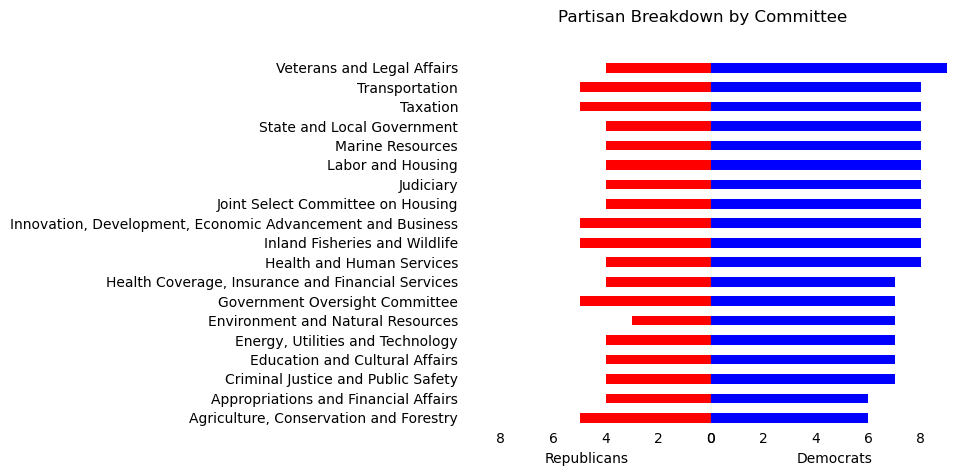

In [8]:
# partisanship by committee
fig, axs = plt.subplots(1,2, sharey=True)

# calculate partisan lean for sorting
committee_counts = members.groupby(["party", "committee"]).count()["name"]
committee_lean = committee_counts['D'] / committee_counts['R'].sort_values()

# plot bar charts, sorting by lean (second plot will follow the same sorting automatically)
committee_counts['D'].loc[committee_lean.sort_values().index].plot.barh(ax=axs[1], color='b', xlabel="Democrats")
committee_counts['R'].plot.barh(ax=axs[0], color="r", xlabel="Republicans")

# scale and format both subplots 
x_range = max(max(axs[0].get_xlim()), max(axs[1].get_xlim()))
for ax in axs:
    ax.set_xlim(0, x_range)
    ax.set_ylabel("")
    ax.set_frame_on(False)
    ax.tick_params(axis='both', which='both',length=0)

# flip the left x axis
axs[0].invert_xaxis()

# remove the gap between axes
fig.subplots_adjust(wspace=0)
fig.suptitle("Partisan Breakdown by Committee");
